Evaluate the 10-day forecast skill for the ML-corrected ("prognostic") simulations. This notebook depends on diagnostics computed by the `prognostic-reports` workflow.

Figure 3 and Figure S3 are generated by this notebook.

In [1]:
import xarray as xr
import fsspec
import os
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.rcParams['figure.dpi'] = 150
xr.set_options(keep_attrs=True)

In [2]:
root_url = 'gs://vcm-ml-archive/prognostic_run_diags'
cache_key = 'vcm-ml-experiments-2020-10-30-nudge-to-obs-GRL-paper-weather-forecasts'
runs = ['baseline', 'rf-control', 'rf-dQ1-dQ2-only']
run_labels = {
    'baseline': 'baseline',
    'rf-control': 'ML-corrected',
    'rf-dQ1-dQ2-only': 'ML-corrected\n($\Delta Q_1$, $\Delta Q_2$ only)'
}
start_times = [f'2016{m:02}01.000000' for m in range(1, 13)]

In [3]:
def plot_lines(mean, std, variables, ylabel=None):
    nrow = int(np.ceil(len(variables)/3))
    fig, axes = plt.subplots(nrow, 3, figsize=(10, 2.6 * nrow))
    axes = axes.flatten()
    colors = ['k', 'r', 'b', 'm']
    for j, name in enumerate(variables):
        ax = axes[j]
        da_mean = mean[name]
        da_std = std[name]
        x = da_mean.time
        for i, exp in enumerate(da_mean.experiment):
            exp = exp.values.item()
            y = da_mean.sel(experiment=exp)
            spread = da_std.sel(experiment=exp)
            ax.plot(x, y, color=colors[i], linewidth=0.8, label=exp)
            ax.fill_between(x, y - spread, y + spread, color=colors[i], alpha=0.1)
        ax.set_title(da_mean.attrs['long_name'])
        ax.set_xlim([0, 10])
        ax.set_xlabel('time elapsed [days]')
        ax.set_xticks(range(0, 11))
        if ylabel:
            ax.set_ylabel(f"{ylabel} [{da_mean.units}]")
        else:
            ax.set_ylabel(f"{da_mean.units}")
        ax.grid()
        if j == 0:
            ax.legend()
    fig.tight_layout(pad=0.1)

### Load diagnostics

In [4]:
diags = []
for run in runs:
    run_diags = []
    for time in start_times:
        diag_url = os.path.join(root_url, f'{cache_key}-{time}_{run}', 'diags.nc')
        with fsspec.open(diag_url) as f:
            ds = xr.open_dataset(f).load()
        dt = ds.time.values[1] - ds.time.values[0]
        time_values = [t.days * 86400 + t.seconds for t in ds.time.values - ds.time.values[0]]
        new_time_coord = xr.DataArray(time_values, name="time")
        new_time_coord.values[:] = new_time_coord.values[:] + dt.seconds
        new_time_coord = (new_time_coord / 3600.0 / 24).assign_attrs(units="days")
        ds = ds.assign_coords(time=new_time_coord.values)
        run_diags.append(ds.assign_coords(start_time=time))
    run_diags = xr.concat(run_diags, dim='start_time').assign_coords(experiment=run_labels[run])
    diags.append(run_diags)
diags = xr.concat(diags, dim='experiment')

In [5]:
diags_mean = diags.mean('start_time')
diags_std = diags.std('start_time')

/home/OliWM/miniconda3/envs/fv3net/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/OliWM/miniconda3/envs/fv3net/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


### Plot RMSE errors averaged over 12 start dates
Shading shows +/- one standard deviation

### Figure 3

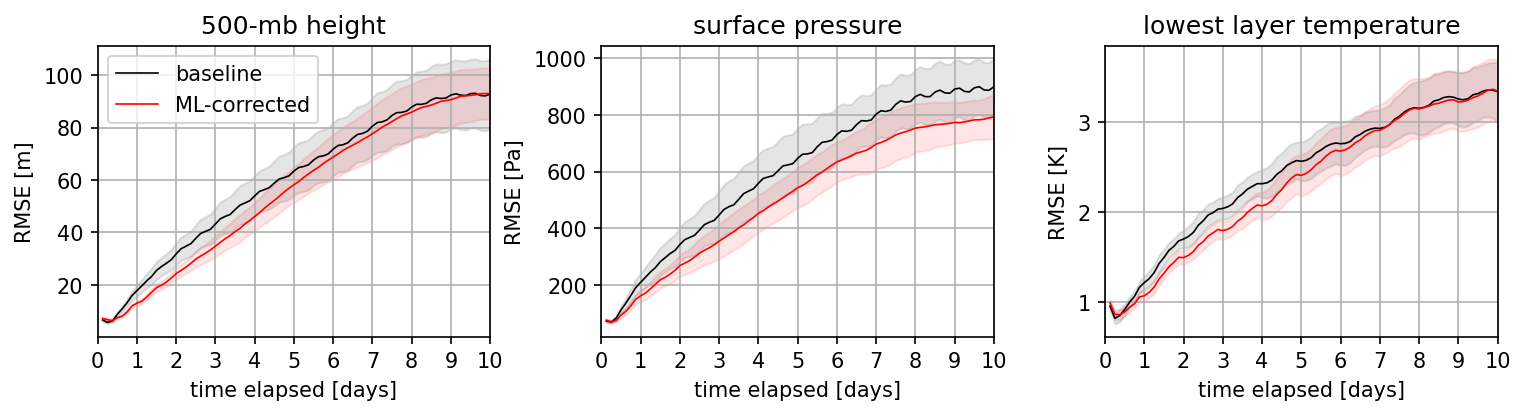

In [6]:
paper_vars = ['h500_rms_global', 'pressfc_rms_global', 'tmplowest_rms_global']
plot_runs = ['baseline', 'ML-corrected']
# just baseline and rf-control
plot_lines(diags_mean.sel(experiment=plot_runs), diags_std.sel(experiment=plot_runs), paper_vars, ylabel='RMSE')

### Figure S3

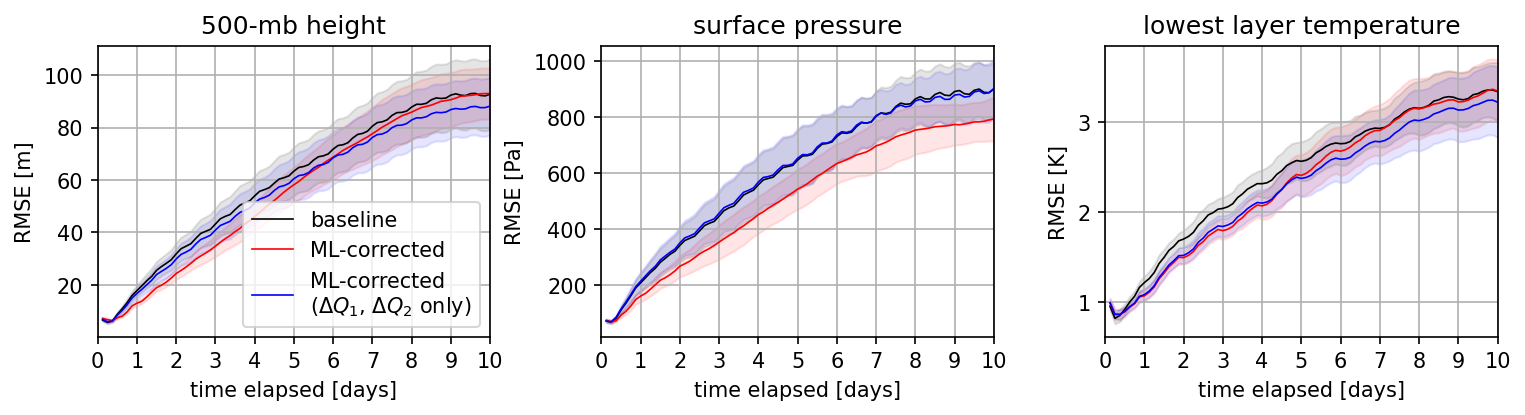

In [7]:
# all three experiments
plot_lines(diags_mean, diags_std, paper_vars, ylabel='RMSE')